### This Note book is dedicated to compute Graphs and Testing

In [1]:
import os
import numpy as np
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
import scipy
import nibabel as nib
from nilearn import image
import nibabel as nib
import matplotlib.pyplot as plt

### usefull functions for testing types

In [48]:
## Correlation between annotations

def cosine_between_annotations(annotations1, annotations2):
    """
    Compute the cosine similiarity between two annotations numpy.
    """
    if len(annotations1)>len(annotations2):
        annotations1 = annotations1[:len(annotations2)]
    else:
        annotations2 = annotations2[:len(annotations1)]
    cosine = cosine_similarity(annotations1.reshape(1,-1), annotations2.reshape(1,-1))
    return cosine ,len(annotations1),len(annotations2)

## Plot annotations according to moving average
def plot_annotation(annotations, window_size=10):
    """
    Plot the annotations with a moving average.

    Parameters:
        annotations (numpy array): The annotation values to be smoothed.
        window_size (int): The size of the moving average window.

    Returns:
        numpy array: The smoothed annotations.
    """
    if len(annotations.shape) > 1:  # Ensure it's 1D
        annotations = annotations.flatten()

    # Apply moving average
    window = np.ones(window_size) / window_size
    smoothed_annotations = np.convolve(annotations, window, mode='same')
    smoothed_annotations = np.convolve(annotations.flatten(), window, mode='full')[window_size-1:len(annotations)+window_size-1].reshape(-1, 1)  # Future-only averaging

    # Plot
    plt.figure(figsize=(14, 4))
    plt.scatter(range(len(annotations)), annotations, label="Original Binary Data", color="black", alpha=0.6, s=10)
    plt.plot(smoothed_annotations, label=f"Smoothed (window={window_size})", color="red",alpha=0.5, linewidth=1)
    
    plt.xlabel("TR")
    plt.ylabel("Annotation Value")
    plt.title("Binary Annotations with Moving Average Smoothing")
    ## move the legend

    plt.legend(loc='upper right')
    plt.ylim(-0.1, 1.1)  # Keep within binary range
    plt.show()

    return smoothed_annotations

import os
import numpy as np
import nibabel as nib
def auc(annot1,annot2):
    """
    Compute the AUC between two annotations.
    """
    if len(annot1)>len(annot2):
        annot1 = annot1[:len(annot2)]
    else:
        annot2 = annot2[:len(annot1)]
    auc = roc_auc_score(annot1, annot2)
    return auc

def agg_trials(base_path, regions, model_name, n_trials, n_top_values=100):
    """
    Process multiple brain regions and extract their top voxel values over multiple trials.

    Parameters:
    -----------
    base_path : str
        Base path to the results directory.
    regions : list
        List of brain region names (folder names).
    model_name : str
        Name of the model used in the file naming convention.
    n_trials : int
        Number of trials to process.
    n_top_values : int
        Number of top voxel values to consider per trial.

    Returns:
    --------
    dict : Dictionary with region names as keys and lists of mean top voxel values for each trial.
    """
    # Initialize dictionary to store mean values for each trial
    region_values = {region: [] for region in regions}

    for trial in range(1, n_trials + 1):  # Iterate through all trials
        for region in regions:
            # Construct path for the NIfTI file
            nii_path = os.path.join(base_path, f"llava_video_TRrange_onlysocial_{region}", "group", model_name, f"trial_{trial}", f"{model_name}_r.nii")
            
            # Check if the file exists
            if not os.path.exists(nii_path):
                print(f"⚠️ Warning: Missing file {nii_path}")
                region_values[region].append(None)  # Mark as missing for this trial
                continue
            
            # Load and process data
            img = nib.load(nii_path)
            data = img.get_fdata()
            data = data.flatten()

            # Remove NaNs and select top 100 values
            top_values = np.sort(data[~np.isnan(data)])[-n_top_values:]

            # Store mean value for this trial
            region_values[region].append(top_values.mean())

    return region_values

def agg_trials2(base_path, regions, model_name, n_trials, n_top_values=100):
    """
    Process multiple brain regions and extract their top voxel values over multiple trials.

    Parameters:
    -----------
    base_path : str
        Base path to the results directory.
    regions : list
        List of brain region names (folder names).
    model_name : str
        Name of the model used in the file naming convention.
    n_trials : int
        Number of trials to process.
    n_top_values : int
        Number of top voxel values to consider per trial.

    Returns:
    --------
    dict : Dictionary with region names as keys and lists of mean top voxel values for each trial.
    """
    # Initialize dictionary to store mean values for each trial
    region_values = {region: [] for region in regions}

    for trial in range(1, n_trials + 1):  # Iterate through all trials
        for region in regions:
            # Construct path for the NIfTI file
            model_name = f"llava_{trial}TR_video"
            nii_path = os.path.join(base_path, f"llava_video_TRrange_onlysocial_{region}", "group",model_name, f"trial_{trial}",f"{model_name}_r.nii")
            
            # Check if the file exists
            if not os.path.exists(nii_path):
                print(f"⚠️ Warning: Missing file {nii_path}")
                region_values[region].append(None)  # Mark as missing for this trial
                continue
            
            # Load and process data
            img = nib.load(nii_path)
            data = img.get_fdata()
            data = data.flatten()

            # Remove NaNs and select top 100 values
            top_values = np.sort(data[~np.isnan(data)])[-n_top_values:]

            # Store mean value for this trial
            region_values[region].append(top_values.mean())

    return region_values
def csv_to_annotation(csv_path, output_path,repeat):
    """
    Convert a CSV file to a NIfTI annotation file.

    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file.
    output_path : str
        Path to save the output NIfTI file.
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    data = np.array(df["response"])
    # Repeat the data to match the desired shape
    data = np.repeat(data, repeat)
    data = np.where(data == "Y", 1, 0).astype(np.float32)

    annot2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/social_nonsocial.npy")
    print(annot2.shape)
    anima = annot2[:27].flatten()
    t1 = data[:946]
    t2 = data[946:]
    data = np.concatenate((anima,t1, anima,t2), axis=0)


    data = data.reshape(-1,1)  # Reshape to 2D array (1 row, n columns)
    print(data.shape)
    # Save the NIfTI image
    np.save(output_path, data)


In [47]:
durations = {"3.0":2,"4.5":3,"6.0":4,"7.5":5,"9.0":6,"10.5":7,"12.0":8,"13.5":9}

for i in durations.keys():
    csv_to_annotation(f"/home/new_storage/sherlock/STS_sherlock/projects data/Sherlock/llava_{i}s_video_resultsnew.csv", f"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_{i}s_video.npy", durations[i])


(1976, 1)
(1954, 1)
(1976, 1)
(1944, 1)
(1976, 1)
(1934, 1)
(1976, 1)
(1954, 1)
(1976, 1)
(1914, 1)
(1976, 1)
(1944, 1)
(1976, 1)
(1894, 1)
(1976, 1)
(1944, 1)


In [72]:
annot.shape

In [73]:
np.save(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\llava_6s_video_results_primitives.npy", annot)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import numpy as np



# Smoothing
window_size =1
annot = np.convolve(annot.flatten(), np.ones(window_size) / window_size, mode='full')[:len(annot)]




annot2[annot2 == -1] = 0
annot[annot == -1] = 0
annot = annot[:len(annot2)]
annot = annot.flatten()

# Descriptive stats
print("Cosine similarity:", cosine_between_annotations(annot, annot2))
print("Recall:", recall_score(annot, annot2))
print("Precision:", precision_score(annot2, annot))
print("F1:", f1_score(annot2, annot))
print("Accuracy:", accuracy_score(annot2, annot))

# Confusion matrix
cm = confusion_matrix(annot2, annot)
print("Confusion Matrix:\n", cm)


In [ ]:
print(annot)

In [4]:
annot.shape

In [59]:
annot = np.load(r'C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\llava_social_speak_full.npy')
plot_annotation(annot, window_size=7)

In [83]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ 'lateral_occipital',"sts","ffa"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
results = agg_trials(base_path, regions, n_trials=40, n_top_values=80, model_name="llava_only_social")

# Access values for each region

lateral_occipital_values = results['lateral_occipital']
sts_values = results['sts']
ffa_values = results['ffa']

# Plot the results
trials = range(1, 41)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Trial")
plt.ylabel("Mean Top Voxel Value")
plt.title("Mean Top Voxel Value for Lateral Occipital and STS Regions")
plt.legend()
plt.grid(True)
plt.show()

## smooth this data



In [86]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ "sts"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
results = agg_trials(base_path, regions, n_trials=40, n_top_values=80, model_name="llava_only_social")

# Access values for each region


sts_values = results['sts']


# Plot the results
trials = range(1, 41)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Trial")
plt.ylabel("Mean Top Voxel Value")
plt.title("Mean Top Voxel Value for Lateral Occipital and STS Regions")
plt.legend()
plt.grid(True)
plt.show()

## smooth this data



⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_sts/group/llava_only_social/trial_1/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_ffa/group/llava_only_social/trial_1/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_lateral_occipital/group/llava_only_social/trial_1/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_sts/group/llava_only_social/trial_2/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_ffa/group/llava_only_social/trial_2/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/lavva_1TR_onlysocial_lateral_occipital/group/llava_only_social/tr

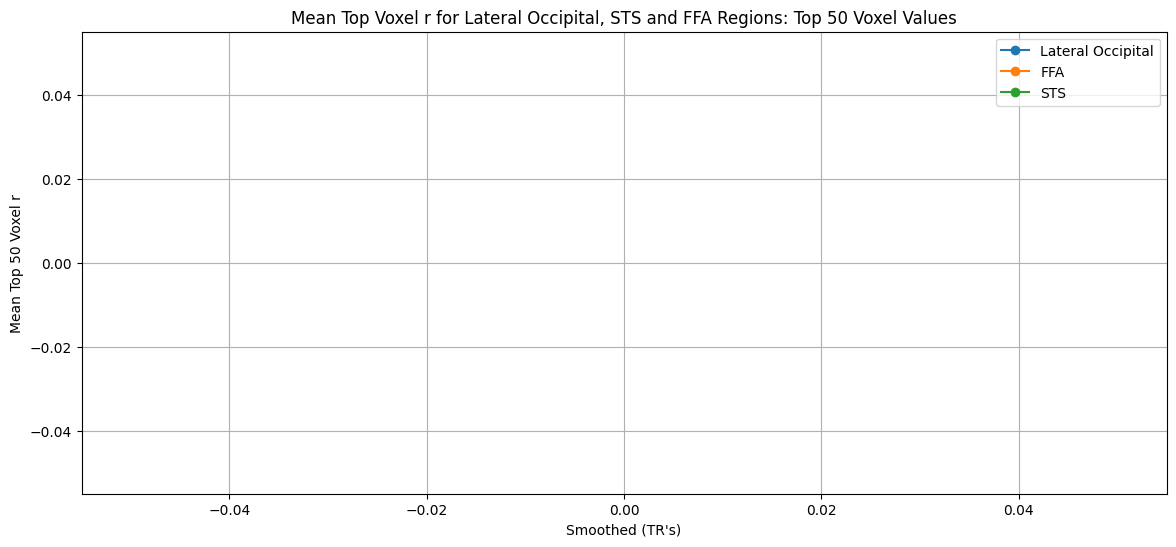

In [4]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ "sts","ffa","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=50
results = agg_trials(base_path, regions, n_trials=30, n_top_values=n, model_name="llava_only_social")

# Access values for each region


sts_values = results['sts']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['ffa']

# Plot the results
trials = range(0, 30)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Smoothed (TR's)")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values")
plt.legend()
plt.grid(True)
plt.show()




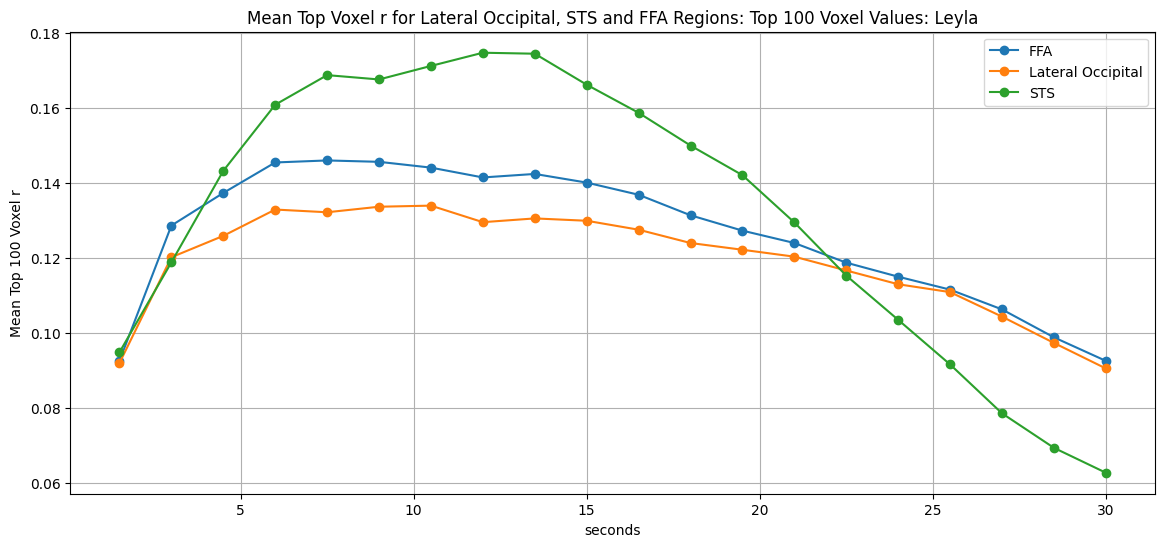

In [7]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_1TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




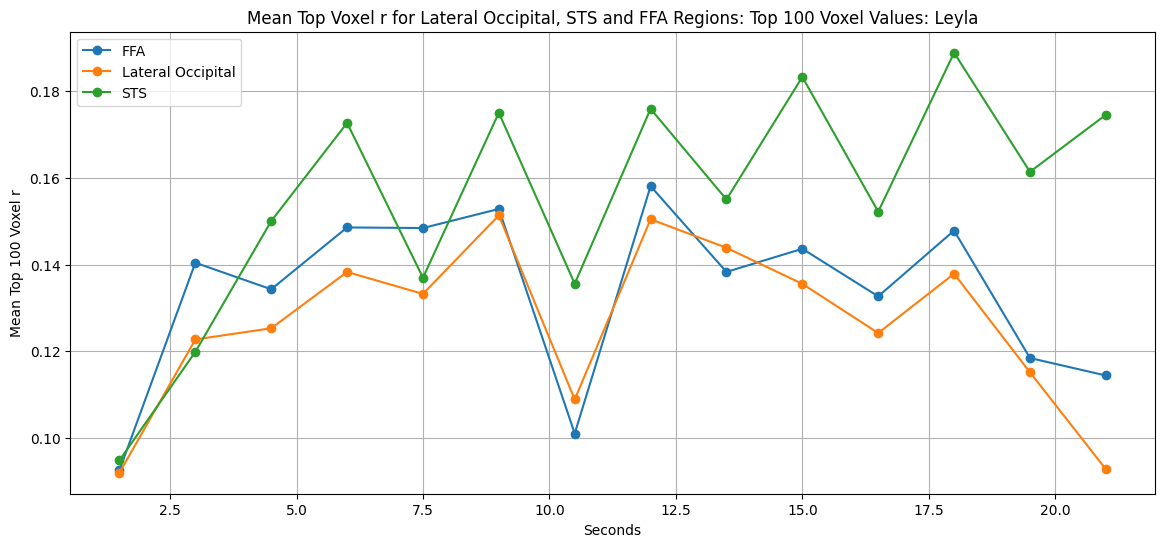

In [6]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials2(base_path, regions, n_trials=14, n_top_values=n, model_name="llava_TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 15)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




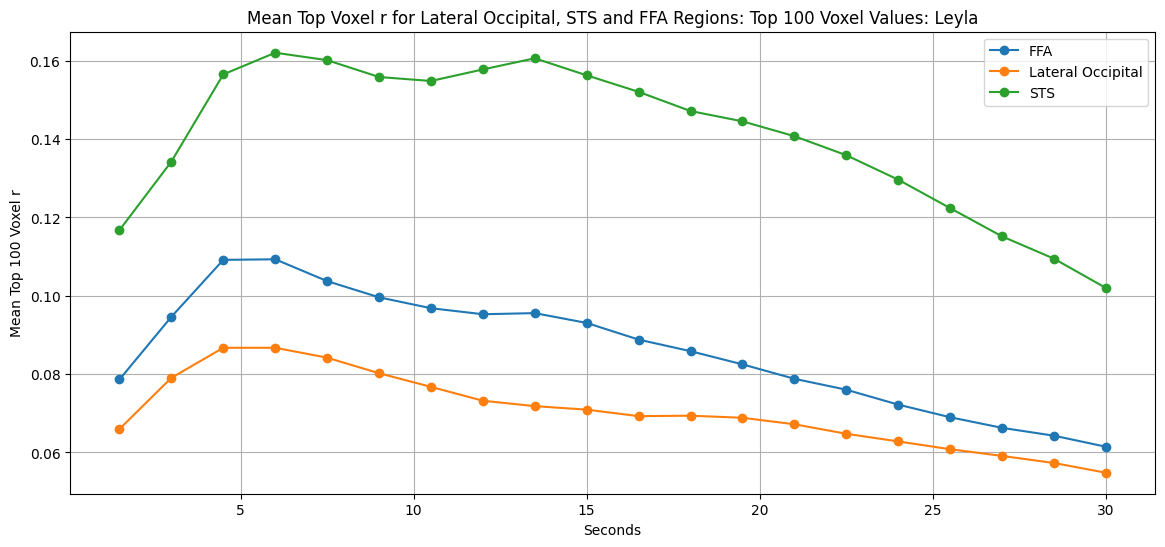

In [45]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_1TR_video")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital

# Plot the results
trials = range(1, 21)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




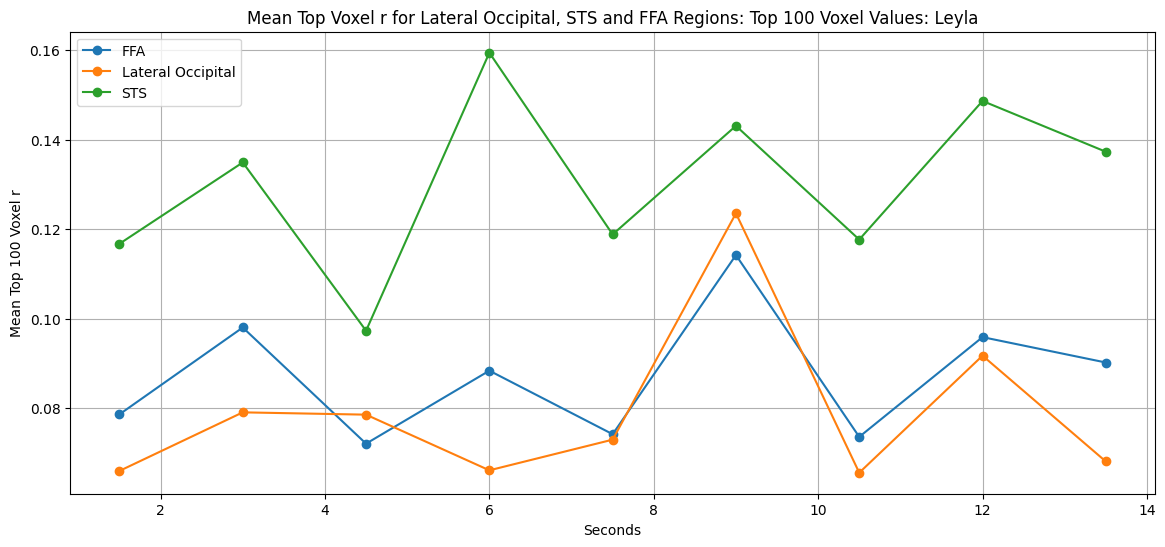

In [49]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials2(base_path, regions, n_trials=9, n_top_values=n, model_name="llava_TR_video")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 10)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




In [19]:
def apply_mask(data, mask):
    if mask is not None:
        #mask_data = nib.load(mask).get_fdata()
        #new_mask = mask_data > 0.25
        # get the indices of the mask
        mask_indices = np.where(mask)
        new_data = data[mask_indices]
        return new_data, mask_indices
    else:
        mask_indices = np.where(np.ones(data.shape[:3])) 
        new_data = data[mask_indices]  
        return new_data, mask_indices


In [5]:
annot = np.load(r'C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\social_nonsocial.npy')

In [6]:
annot.shape

In [26]:
fmri_sts,id = apply_mask(fmri,sts_mask)
fmri_ffa,id = apply_mask(fmri,ffa_maks)

## not that the data is masked, let's take only the events where there was social interaction fmri has dims (x,t)
id = np.where(annot==1)
fmri_sts = fmri_sts[:,id[0]]
fmri_ffa = fmri_ffa[:,id[0]]

In [27]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
# Define TR (Repetition Time in seconds)
TR = 1.5  # Given TR value
fs = 1 / TR  # Sampling frequency (Hz)

# Average across voxels (time series shape is now (time_points,))
fmri_sts = np.mean(fmri_sts, axis=0)  # (time_points,)
#fmri_sts = fmri_sts.flatten()
# Compute PSD using Welch's method
freqs, psd = signal.welch(fmri_sts, fs=fs, nperseg=512)  # No need for axis argument

# Plot the averaged PSD
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd, label="Mean PSD Across Voxels", color='b')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Mean PSD of fMRI Signals (STS Masked Voxels)')
plt.legend()
plt.show()
# Define TR (Repetition Time in seconds)
TR = 1.5  # Given TR value
fs = 1 / TR  # Sampling frequency (Hz)

# Average across voxels (time series shape is now (time_points,))
fmri_ffa = np.mean(fmri_ffa, axis=0)  # (time_points,)
#fmri_ffa = fmri_ffa.flatten()

# Compute PSD using Welch's method
freqs, psd = signal.welch(fmri_ffa, fs=fs, nperseg=512)  # No need for axis argument

# Plot the averaged PSD
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd, label="Mean PSD Across Voxels", color='b')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Mean PSD of fMRI Signals (FFA Masked Voxels)')
plt.legend()
plt.show()

In [253]:
# Define TR (Repetition Time in seconds)
TR = 1.5  
fs = 1 / TR  # Sampling frequency (Hz)

# Define frequency range of interest (e.g., 0.01 Hz to 0.3 Hz for slow fMRI fluctuations)
freqs_of_interest = np.linspace(0.01, 0.15, 30)  # Define 30 frequency points in this range

# Convert frequencies to wavelet scales
# Morlet wavelet central frequency factor is ~6
scales = fs / (2 * freqs_of_interest)

# Compute Morlet Wavelet Transform
cwt_sts_matrix = signal.cwt(fmri_sts, signal.morlet2, scales, w=6)  # w=6 gives good time-frequency resolution

# Plot the time-frequency representation
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_matrix), aspect='auto', extent=[0, fmri_sts.shape[0] * TR, freqs_of_interest[0], freqs_of_interest[-1]], cmap='jet', origin='lower')

plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Morlet Wavelet Transform of fMRI Signal STS')
plt.show()

In [254]:
# Define TR (Repetition Time in seconds)
TR = 1.5  
fs = 1 / TR  # Sampling frequency (Hz)

# Define frequency range of interest (e.g., 0.01 Hz to 0.3 Hz for slow fMRI fluctuations)
freqs_of_interest = np.linspace(0.01, 0.15, 30)  # Define 30 frequency points in this range

# Convert frequencies to wavelet scales
# Morlet wavelet central frequency factor is ~6
scales = fs / (2 * freqs_of_interest)

# Compute Morlet Wavelet Transform
cwt_ffa_matrix = signal.cwt(fmri_ffa, signal.morlet2, scales, w=6)  # w=6 gives good time-frequency resolution

# Plot the time-frequency representation
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_matrix), aspect='auto', extent=[0, fmri_sts.shape[0] * TR, freqs_of_interest[0], freqs_of_interest[-1]], cmap='jet', origin='lower')

plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Morlet Wavelet Transform of fMRI Signal FFA')
plt.show()

In [262]:
cwt_ffa_matrix = cwt_ffa_matrix[:15,:]
cwt_sts_matrix = cwt_sts_matrix[:15,:]

y= np.mean(cwt_sts_matrix,axis=1)
x= np.mean(cwt_ffa_matrix,axis=1)
print(y-x)


In [9]:
fmri = image.load_img(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\fmri_data\C4\sub21\derivatives\sub-21_task-citizenfour_bold_blur_no_censor_ica.nii.gz")

In [16]:
# Get header info
header = fmri.header
data = fmri.get_fdata()
# Print key metadata
print("Shape:", fmri.shape)
print("TR (Repetition Time):", header.get_zooms()[3], "seconds")
print("Voxel dimensions:", header.get_zooms()[:3])
print("Datatype:", header.get_data_dtype())
print(fmri.shape, np.nanmax(fmri), np.nanmin(fmri))

In [17]:
print(np.nanmax(data), np.nanmin(data), np.mean(data), np.std(data))

In [3]:
ann=np.load(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\annotation_c4.npy")

In [4]:
ann.shape

In [11]:
## add a dim
ann = ann.reshape(-1,1)

In [14]:
np.save(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\annotation_c4.npy",ann)